In [ ]:
import numpy as np
from numpy import polyfit
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import h5py
import numpy as np
from matplotlib.pyplot import figure,show
from swiftsimio import load
import pandas as pd
from scipy.stats import norm
import matplotlib.mlab as mlab
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root, minimize
from lmfit.models import LorentzianModel, VoigtModel, GaussianModel,LognormalModel
from scipy.integrate import fixed_quad, quad, dblquad


# Pairwise velocities calculation

## Pairwise binning

In [ ]:
path_hydro= "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"
with h5py.File(path_hydro, "r") as handle:
    TotalMass= handle["ExclusiveSphere/100kpc/TotalMass"][:]
    StellarMass = handle["ExclusiveSphere/100kpc/StellarMass"][:]
    COMstellarvelocity=handle["ExclusiveSphere/100kpc/StellarCentreOfMassVelocity"][:]
    COMvelocity=handle["ExclusiveSphere/100kpc/CentreOfMassVelocity"][:]
    Trackid=handle["InputHalos/HBTplus/TrackId"][:]
    HOSTFOFID=handle["InputHalos/HBTplus/HostFOFId"][:]
    HaloCatalogueIndex=handle["InputHalos/HaloCatalogueIndex"][:]
    HOSTHALOINDEX=handle["SOAP/HostHaloIndex"][:]
    FOFMass=handle["InputHalos/FOF/Masses"][:]
    NoofBoundParticles=handle["InputHalos/NumberOfBoundParticles"][:]
    NoofDMParticles=handle["ExclusiveSphere/100kpc/NumberOfDarkMatterParticles"][:]
    COM=handle["ExclusiveSphere/100kpc/CentreOfMass"][:]
    IsCentral=handle["InputHalos/IsCentral"][:]
    

In [ ]:
df = pd.DataFrame({
    'HOST_FOF' :  HOSTFOFID,
    'HostHaloIndex':HOSTHALOINDEX, # -1 for central halos
    'Catalogue Index': HaloCatalogueIndex,
    'Track ID' : Trackid,
    'mass':TotalMass,
    'FOFMass':FOFMass,
    'COM v- x':COMvelocity[:,0],
    'COM v- y':COMvelocity[:,1],
    'COM v- z':COMvelocity[:,2],
    'COM - x':COM[:,0],
    'COM - y':COM[:,1],
    'COM - z':COM[:,2],
    'Bound Particles No':NoofBoundParticles,
    'DM Particles No': NoofDMParticles,
    'CENTRAL':IsCentral
})
df['INDEX_HOST_HALOS']=np.asarray(df.index)

DF_BOUND_NO_FILTERED= df[df['Bound Particles No']>100]
#to get an idea of how many primary halos there are (primary_centrals)
primary=DF_BOUND_NO_FILTERED[(DF_BOUND_NO_FILTERED['FOFMass'] > 10**3) & (DF_BOUND_NO_FILTERED['FOFMass'] < 10**3.5)]
primary_centrals=primary[primary['HostHaloIndex']==-1]
# display(primary_centrals)

#sets the range of mass to be considered for M2, i.e. mass of the 'secondary' halo in a pair of halos
secondary=DF_BOUND_NO_FILTERED[(DF_BOUND_NO_FILTERED['FOFMass'] > 10**3.5) & (DF_BOUND_NO_FILTERED['FOFMass'] < 10**5.5)]
secondary_centrals=secondary[secondary['CENTRAL']==1]
# display(secondary_centrals)
# len(np.unique(secondary_centrals['INDEX_HOST_HALOS']))

,HOST_FOF,HostHaloIndex,Catalogue Index,Track ID,mass,FOFMass,COM v- x,COM v- y,COM v- z,COM - x,COM - y,COM - z,Bound Particles No,DM Particles No,CENTRAL,INDEX_HOST_HALOS
2,8819253,-1,1388,120354,243.75,1126.0,-294.951538,126.548462,-304.751526,20.143684,21.242504,15.924304,2427,393,1,2
6,8818184,-1,4277,607307,355.00,1804.0,-313.151550,236.248474,-193.451538,16.115784,10.261374,8.260274,3966,565,1,6
30,8818373,-1,27150,4058446,192.25,1572.0,-281.851501,181.348450,-522.051514,21.578814,16.398624,24.370184,2271,296,1,30
382,8818821,-1,182935,710241,179.50,1306.0,-177.151550,506.548523,53.048462,3.065634,3.682654,7.983174,1433,292,1,382
383,8817880,-1,182939,1293567,163.50,2064.0,-110.551514,514.948425,-253.951538,3.911364,3.013984,15.382074,3111,261,1,383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15299971,10344171,-1,30856727,3220515,276.50,2996.0,44.750610,619.950562,44.650574,986.574258,984.948608,953.592768,6181,426,1,15299971
15299981,10344849,-1,30862413,4051682,273.50,1712.0,189.750610,437.950562,-16.649414,984.897738,985.108318,951.239618,3262,421,1,15299981
15300462,10344528,-1,30856715,3220502,256.50,2204.0,-76.518494,945.481567,-232.618469,974.874865,990.168415,977.331045,4300,404,1,15300462
15300577,10344706,-1,30927215,740979,240.75,1884.0,-195.118469,412.981567,-168.718506,997.010025,994.413715,982.817785,4130,384,1,15300577


,HOST_FOF,HostHaloIndex,Catalogue Index,Track ID,mass,FOFMass,COM v- x,COM v- y,COM v- z,COM - x,COM - y,COM - z,Bound Particles No,DM Particles No,CENTRAL,INDEX_HOST_HALOS
1748,10511972,-1,233459,289695,620.0,4432.0,-172.187012,-468.287048,-333.687073,30.114830,2.639570,182.861400,11092,997,1,1748
2227,10511627,-1,234719,291183,400.0,8832.0,-51.560425,-92.060425,-51.060425,10.327862,12.892012,213.911062,16021,626,1,2227
2228,10512003,-1,234721,291186,332.0,4456.0,-340.860474,-245.260376,237.639526,18.825362,15.844252,208.640512,4181,534,1,2228
2242,10511945,-1,240289,1145525,324.5,4640.0,-292.760376,263.939575,-172.160400,15.705102,12.095932,212.913212,8861,502,1,2242
2860,10511567,-1,234238,290617,585.0,10224.0,-411.060425,-31.660400,-424.060425,30.072352,17.767152,221.097422,13876,942,1,2860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15299952,10343845,-1,30838343,287085,352.0,4224.0,109.350586,937.650635,-246.749390,991.723598,982.084008,958.583508,7533,542,1,15299952
15299954,10343536,-1,30839340,604803,486.5,7688.0,218.250610,506.750610,-146.549438,988.827658,984.761798,958.013558,16897,753,1,15299954
15300442,10343339,-1,30837051,119461,820.0,15168.0,40.281494,503.281494,-262.018494,970.483815,999.919835,976.680265,31477,1269,1,15300442
15300446,10343862,-1,30839334,604796,529.0,3984.0,76.681519,739.781494,-237.418457,995.673295,992.678215,984.580755,9882,838,1,15300446


56469

In [ ]:
box_size = 1e3  # Box size in Mpc (1 Gpc)
half_box = box_size / 2 
halo_ids = secondary_centrals['INDEX_HOST_HALOS'] #  HOST_FOF IDs


masses = secondary_centrals['FOFMass']
positions = np.column_stack((secondary_centrals['COM - x'], secondary_centrals['COM - y'], secondary_centrals['COM - z']))
positions = positions % box_size #if any coordinate value is negative or larger than box size - it gets mapped into the box
velocities = np.column_stack((secondary_centrals['COM v- x'], secondary_centrals['COM v- y'], secondary_centrals['COM v- z']))

# Select "primary" halos - insert values of interest in units of 10**10 MSun
min_mass = 10**4
max_mass = 10**4.5

# Select 'primary' halos by mass
selected_mask = (masses >= min_mass) & (masses <= max_mass)
selected_positions = positions[selected_mask]
selected_velocities = velocities[selected_mask]
selected_masses = masses[selected_mask]
selected_ids = halo_ids[selected_mask]  

# HDF5 file storage - can change buffer size depending on no. of primary halos
buffer_size = 59000
radial_buffer, velocity_buffer, mass_buffer = [], [], []
offset = 0

# print(positions)
print(len(selected_masses))

#here - change file name accordingly
with h5py.File("velocity_data_M14_14_5_trial_largersecondary_newquantity.h5", "w") as f:
    dset_radial = f.create_dataset("radial_distances", (0,), maxshape=(None,), dtype=np.float32, compression="gzip")
    dset_velocities = f.create_dataset("velocity_differences", (0,), maxshape=(None,), dtype=np.float32, compression="gzip")
    dset_masses = f.create_dataset("masses", (0,), maxshape=(None,), dtype=np.float32, compression="gzip")

    for primary_idx, (pos1, vel1, primary_id) in enumerate(zip(selected_positions, selected_velocities, selected_ids)):
        # Positional differences with periodic boundary conditions
        pos_diffs = positions - pos1  
        pos_differences = (pos_diffs + half_box) % box_size - half_box  
        radial_distances = np.linalg.norm(pos_differences, axis=1)  
        
        # Velocity difference
        vel_diffs = velocities - vel1  
        

        # Exclude self-comparison
        mask = halo_ids != primary_id  
        radial_distances_new = radial_distances[mask]
        vel_diffs_new = vel_diffs[mask]
        pos_diffs_new = pos_differences[mask]
        other_masses = masses[mask]

        #Radial unit vector
        radial_units= pos_diffs_new / radial_distances_new[:, np.newaxis]
        
        # Assign signs to velocity magnitude (negative = moving towards primary halo)
        dot_prod= np.einsum('ij,ij->i', vel_diffs_new, radial_units)
        signed_velocity_diffs =dot_prod 
        radial_buffer.extend(radial_distances_new)
        velocity_buffer.extend(signed_velocity_diffs)
        mass_buffer.extend(other_masses)

        offset += len(radial_distances_new)

        # Write to file when buffer is full
        if len(radial_buffer) >= buffer_size:
            new_size = offset
            dset_radial.resize((new_size,))
            dset_velocities.resize((new_size,))
            dset_masses.resize((new_size,))
            dset_radial[offset - len(radial_buffer):offset] = radial_buffer
            dset_velocities[offset - len(radial_buffer):offset] = velocity_buffer
            dset_masses[offset - len(radial_buffer):offset] = mass_buffer

            radial_buffer, velocity_buffer, mass_buffer = [], [], [] 

    # Write remaining buffer data
    if radial_buffer:
        new_size = offset
        dset_radial.resize((new_size,))
        dset_velocities.resize((new_size,))
        dset_masses.resize((new_size,))
        dset_radial[offset - len(radial_buffer):offset] = radial_buffer
        dset_velocities[offset - len(radial_buffer):offset] = velocity_buffer
        dset_masses[offset - len(radial_buffer):offset] = mass_buffer

    f.flush()  

print("Data stored.")


11666
Data stored.


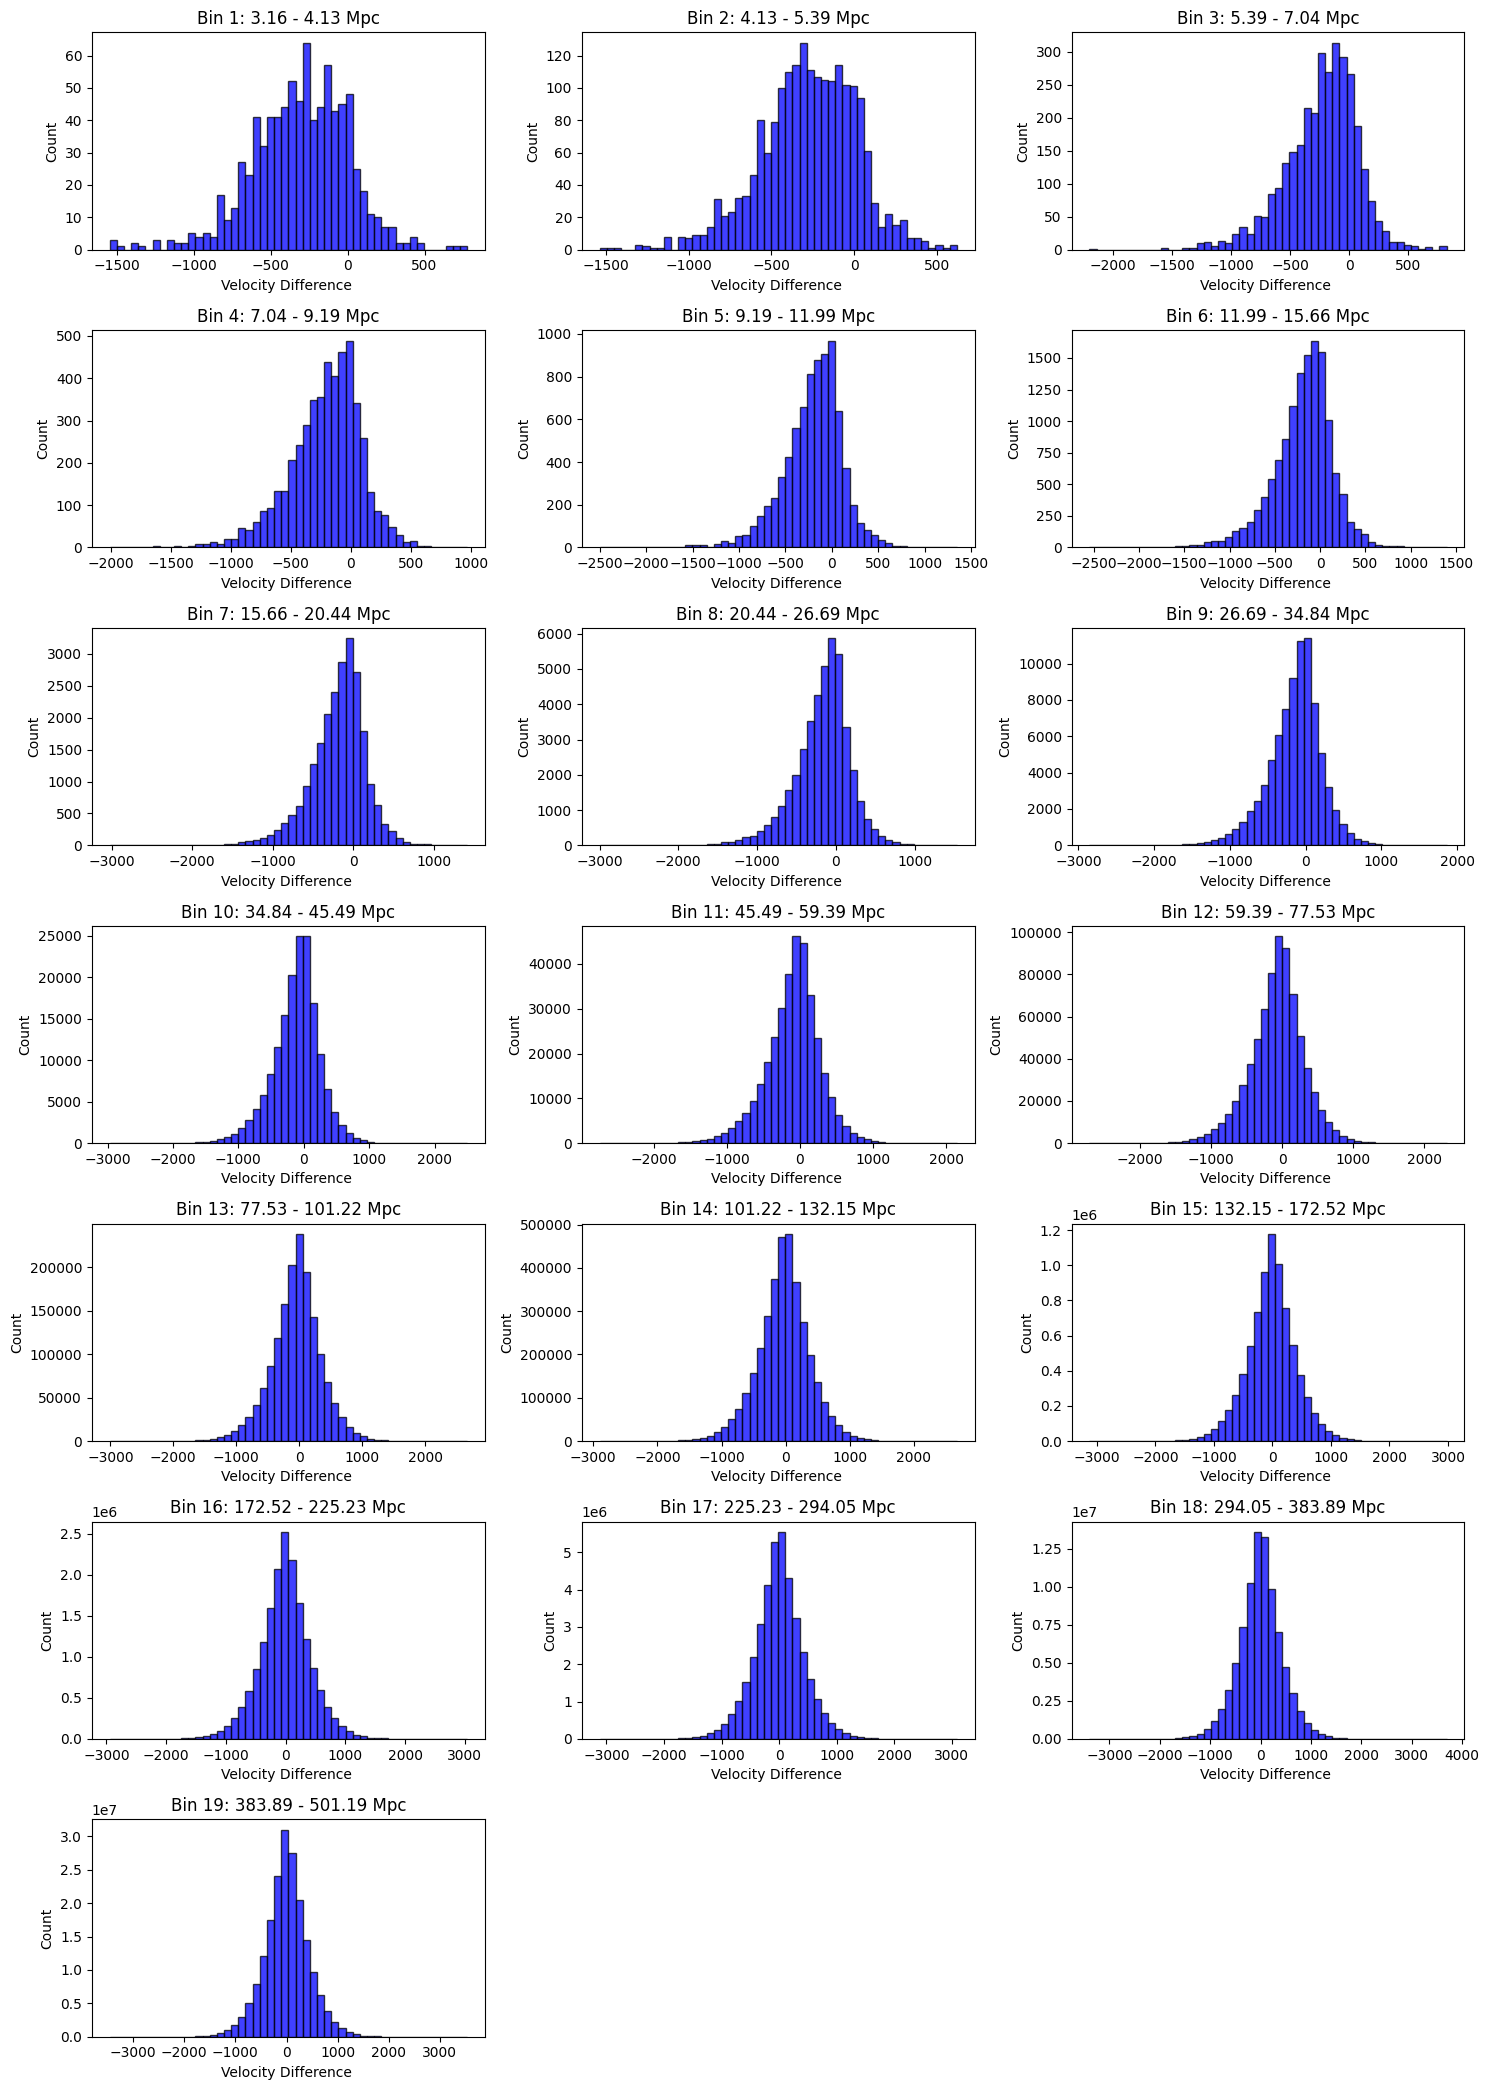

In [7]:
# Define radial bins
radial_bins = np.logspace(0.5, 2.7, 20).astype(np.float32)

with h5py.File("velocity_data_M14_14_5_trial_NORMAL_SIGMA_largersecondary_newquantity_lowsigma8.h5", "r") as f:
    radial_distances = f["radial_distances"][:]
    velocities = f["velocity_differences"][:]
    
# np.max(radial_distances)
bin_indices = np.digitize(radial_distances, bins=radial_bins) - 1
num_bins = len(radial_bins) - 1  


num_cols = 3
num_rows = int(np.ceil(num_bins / num_cols))  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()  


for bin_idx in range(num_bins):
    bin_mask = bin_indices == bin_idx
    bin_velocities = velocities[bin_mask]
    
    if len(bin_velocities) == 0:
        continue
    
    ax = axes[bin_idx]
    ax.hist(bin_velocities, bins=50, alpha=0.75, color='b', edgecolor='black')
    ax.set_xlabel("Velocity Difference ")
    ax.set_ylabel("Count")
    ax.set_title(f"Bin {bin_idx + 1}: {radial_bins[bin_idx]:.2f} - {radial_bins[bin_idx + 1]:.2f} Mpc")


for i in range(num_bins, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig("velocity_histograms_new2halo.png", dpi=700)
plt.show()